In [94]:
import os
from os.path import abspath, join
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image
from skimage import io
from sklearn.preprocessing import MinMaxScaler
import cv2
from tqdm import tqdm
from skimage import measure

In [95]:
# Read in raw data file
# Read in mask
raw = io.imread(abspath("../data/N-2016-2156-1_hBN220215_11038-38401_component_data.tif"))

# Read in tiff
mask = io.imread(abspath("../data/N-2016-2156-1_hBN220215_11038-38401_mask.tif"))

# Read in post-MCMicro data
data = pd.read_csv(abspath("../data/mcmicro_quants/mesmer-N-2016-2156-1_hBN220215_11038-38401_cell.csv"), index_col="CellID")
raw.shape
print(raw.shape)

(7, 1400, 1868)


In [96]:
raw.shape[2]*0.5*0.1

93.4

In [97]:
def get_scale_bar_fos(im_dim, scale, um):
    return um/(im_dim[2]* scale)

scale_bar_fos = get_scale_bar_fos(raw.shape, 0.5, 50)
scale_bar_fos

0.05353319057815846

In [98]:
# Define a min max scaler function so the final image doesn't look ugly
def min_max_scaler(im):
    return ((im-im.min())/(im.max()-im.min()))

In [99]:
# Select one channel and min max scale it
DAPI = raw[0]
DAPI = min_max_scaler(DAPI)
NCAM1 = raw[3]
NCAM1 = min_max_scaler(NCAM1)
SOX10 = raw[5]
SOX10 = min_max_scaler(SOX10)
CD68 = raw[2]
CD68 = min_max_scaler(CD68)

In [100]:
def grayscale2rgbcolor(im, color=(1, 1, 1)):
    # Convert gray scale image to RGB
    r = np.multiply(im, color[0], casting="unsafe")
    r = np.where(r>1, 1, r)

    g = np.multiply(im, color[1], casting="unsafe")
    g = np.where(g>1, 1, g)

    b = np.multiply(im, color[2], casting="unsafe")
    b = np.where(b>1, 1, b)

    # Stack channels
    bgr = np.stack([b, g, r], axis=-1)

    return np.uint8(255*bgr)

In [101]:
# Get channels colored
DAPI_im = grayscale2rgbcolor(DAPI, color = (0.0, 0.2, 1.5)) # Blue
NCAM1_im = grayscale2rgbcolor(NCAM1, color = (1.5, 1.5, 0.3)) # Yellow
SOX10_im = grayscale2rgbcolor(SOX10, color = (2.0, 0.1, 0.1)) # red
CD68_im = grayscale2rgbcolor(CD68, color = (0.0, 2, 0.2)) # green

In [102]:
# Blend channels together
DAPI_CD68   =  cv2.addWeighted(DAPI_im, 1, CD68_im, 1, 0.0)
NCAM1_SOX10 =  cv2.addWeighted(SOX10_im, 1, NCAM1_im, 1, 0.0)
DAPI_NCAM1_SOX10  = cv2.addWeighted(DAPI_im, 1, NCAM1_SOX10, 1, 0.0)

In [103]:
# Get contours for each cell in the mask
# Calculate and draw contours over masked channel

# # Get range of cells
min = mask[np.nonzero(mask)].min()
max = mask[np.nonzero(mask)].max()
print(max-min)

contours = {}
for i in tqdm(range(min, max+1)):
    try:
        y, x = measure.find_contours(mask==i, 0.8)[0].T
        contours[i] = (y, x)
        #ax.plot(x, y, linewidth=3, alpha=0.5, color=color[i])
    except IndexError:
        pass

1254


100%|██████████| 1255/1255 [00:31<00:00, 39.89it/s]


## DAPI

In [104]:
# IN THE CASE OF DAPI WE DO THE SAME PROCESS BUT NO CUTOFF WAS APPLIED
marker = "DAPI"
cutoff = 0
color = data[marker].apply(lambda x: "cyan" if x >= cutoff else "red")

In [105]:
%%time
fig, ax  = plt.subplots(1, 1, figsize=(10, 10))
ax.matshow(DAPI_im[:,:,::-1])
for c, (y, x) in contours.items():
    ax.plot(x, y, linewidth=0.5, alpha=0.6, color=color[c], rasterized=True)
plt.tight_layout()
ax.axhline(y=50, xmin=0.03, xmax=0.03+scale_bar_fos, linewidth=4, color="w",alpha=0.8, linestyle="-")
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.savefig(abspath("../out/overlay-DAPI.pdf"), dpi=600)
plt.savefig(abspath("../out/overlay-DAPI.png"), dpi=600)
plt.close()

CPU times: total: 10.1 s
Wall time: 10.8 s


## CD68

In [106]:
# Get flags
marker = "CD68"
cutoff = 1.756449425220487
color = data[marker].apply(lambda x: "cyan" if x >= cutoff else "red")

In [107]:
%%time
fig, ax  = plt.subplots(1, 1, figsize=(10, 10))
ax.matshow(DAPI_CD68[:,:,::-1])
for c, (y, x) in contours.items():
    ax.plot(x, y, linewidth=0.5, alpha=0.8, color=color[c], rasterized=True)
ax.axhline(y=50, xmin=0.03, xmax=0.03+scale_bar_fos, linewidth=4, color="w",alpha=0.8, linestyle="-")
plt.tight_layout()
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.savefig(abspath("../out/overlay-CD68.pdf"), dpi=600)
plt.savefig(abspath("../out/overlay-CD68.png"), dpi=600)
plt.close()

CPU times: total: 10.5 s
Wall time: 11.4 s


## NCAM1 SOX10

In [108]:
# Get flags
marker = "NCAM1"
cutoff = 1
flag_ncam1 = data[marker]>=cutoff

marker = "SOX10"
cutoff = 1
flag_sox10 = data[marker]>=cutoff

In [109]:
double_positives = flag_ncam1 & flag_sox10
color = double_positives.apply(lambda x: "cyan" if x else "red")

In [110]:
%%time
fig, ax  = plt.subplots(1, 1, figsize=(10, 10))
ax.matshow(DAPI_NCAM1_SOX10[:,:,::-1])
for c, (y, x) in contours.items():
    ax.plot(x, y, linewidth=0.5, alpha=0.8, color=color[c], rasterized=True)
ax.axhline(y=50, xmin=0.03, xmax=0.03+scale_bar_fos, linewidth=4, color="w",alpha=0.8, linestyle="-")
plt.tight_layout()
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.savefig(abspath("../out/overlay-NCAM1SOX10.pdf"), dpi=600)
plt.savefig(abspath("../out/overlay-NCAM1SOX10.png"), dpi=600)
plt.close()

CPU times: total: 10.7 s
Wall time: 11.6 s


## Using a different image for CD138

0.03568879371877231

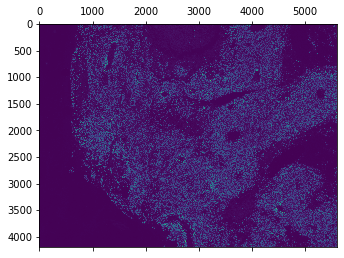

In [111]:
# Read in mask
raw = io.imread(abspath("../data/N-2020-845_Restain_hBN220216_5129-53809_component_data.tif"))

# Read in tiff
mask = io.imread(abspath("../data/N-2020-845_Restain_hBN220216_5129-53809_mask.tif"))

# Read in post-MCMicro data
data = pd.read_csv(abspath("../data/mcmicro_quants/mesmer-N-2020-845_Restain_hBN220216_5129-53809_cell.csv"),  index_col="CellID")
plt.matshow(raw[0])

scale_bar_fos = get_scale_bar_fos(raw.shape, 0.5, 100)
scale_bar_fos

In [112]:
DAPI = raw[0]
DAPI = min_max_scaler(DAPI)
CD138 = raw[4]
CD138 = min_max_scaler(CD138)

In [113]:
DAPI_im = grayscale2rgbcolor(DAPI, color = (0.0, 0.2, 1.5)) # Blue
CD138_im = grayscale2rgbcolor(CD138, color = (0.0, 2, 2)) # Cyan

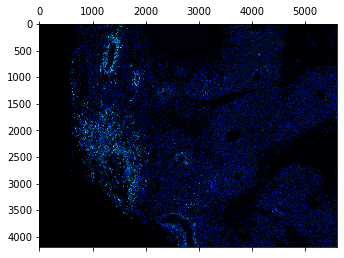

In [114]:
DAPI_CD138 = cv2.addWeighted(DAPI_im, 1, CD138_im, 1, 0.0)
plt.matshow(DAPI_CD138[:,:,::-1])

In [115]:
def slice_image(im, mask , sy=(0, -1), sx=(0, -1)):
    # Subsetting image
    mask = mask[sy[0]:sy[1], sx[0]:sx[1]]
    im = im[sy[0]:sy[1], sx[0]:sx[1]]
    return im, mask


im, mk = slice_image(DAPI_CD138, mask,sy=(250,500), sx=(1250,1500))

print(im.shape)
print(mk.shape)

(250, 250, 3)
(250, 250)


In [116]:
# zoom rate
scale_bar_fos = get_scale_bar_fos(im.shape, 0.5, 50)
scale_bar_fos = scale_bar_fos/100
scale_bar_fos

0.33333333333333337

In [117]:
# # Get range of cells
min = mk[np.nonzero(mk)].min()
max = mk[np.nonzero(mk)].max()
print(max-min)

contours = {}
for i in tqdm(range(min, max+1)):
    try:
        y, x = measure.find_contours(mk==i, 0.8)[0].T
        contours[i] = (y, x)
        #ax.plot(x, y, linewidth=3, alpha=0.5, color=color[i])
    except IndexError:
        pass

1511


100%|██████████| 1512/1512 [00:01<00:00, 1412.06it/s]


In [118]:
# Get flags
marker = "CD138"
cutoff = 1.6312074160575833
color = data[marker].apply(lambda x: "cyan" if x >= cutoff else "red")

In [119]:
%%time
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.matshow(im[:, :, ::-1])
for c, (y, x) in contours.items():
    ax.plot(x, y, linewidth=0.5, alpha=0.8, color=color[c], rasterized=True)
ax.axhline(y=5, xmin=0.03, xmax=0.03+scale_bar_fos, linewidth=4, color="w",alpha=0.8, linestyle="-")
plt.tight_layout()
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.savefig(abspath("../out/overlay-CD138.pdf"), dpi=600)
plt.savefig(abspath("../out/overlay-CD138.png"), dpi=600)
plt.close()

CPU times: total: 10.2 s
Wall time: 11.5 s


In [120]:
# Get flags
marker = "DAPI"
cutoff = 0
color = data[marker].apply(lambda x: "cyan" if x >= cutoff else "red")

In [121]:
%%time
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.matshow(im[:, :, ::-1])
for c, (y, x) in contours.items():
    ax.plot(x, y, linewidth=0.5, alpha=0.8, color=color[c], rasterized=True)
ax.axhline(y=5, xmin=0.03, xmax=0.03+scale_bar_fos, linewidth=4, color="w",alpha=0.8, linestyle="-")
plt.tight_layout()
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.savefig(abspath("../out/overlay-DAPI2.pdf"), dpi=600)
plt.savefig(abspath("../out/overlay-DAPI2.png"), dpi=600)
plt.close()

CPU times: total: 9.55 s
Wall time: 10.4 s
